0.6632909291038274 0.6636751175158019
-0.007706742569798308


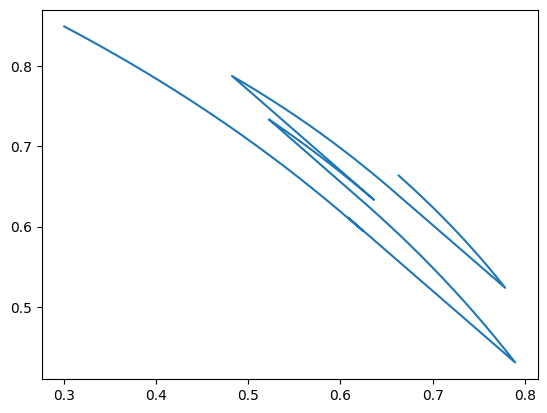

In [45]:
import matplotlib.pyplot as plt

p1=0.3
p2=0.85

def determ(p1, p2):
    return 1 / ((1-p1) * p2) - 1 / (p1 * (1-p2))

def derivs(p1, p2):
    d = determ(p1, p2)
    return (-1/(1-p2) - 1/p2)/d, (1/p1 + 1/(1-p1))/d

eps = 0.002
trajectory = []
derivs_p1 = []
derivs_p2 = []
determs = []
while True:
    dp1, dp2 = derivs(p1, p2)
    p1, p2 = p1 + dp1*eps, p2 + dp2*eps
    derivs_p1.append(dp1)
    derivs_p2.append(dp2)
    trajectory.append((p1, p2))
    d = determ(p1, p2)
    determs.append(d)
    if abs(d) < 0.01:
        break
    
# plot trajectory
plt.plot([x[0] for x in trajectory], [x[1] for x in trajectory])
# # plot derivs_p1 and derivs_p2
# plt.plot(derivs_p1)
# plt.plot(derivs_p2)

print(p1, p2)
print(determ(p1, p2))

In [43]:
from numpy import sqrt

p1=0.3
p2=0.85

sqrt(p1*p2)/(sqrt(p1*p2) + sqrt((1-p1)*(1-p2)))

0.6091287885364286

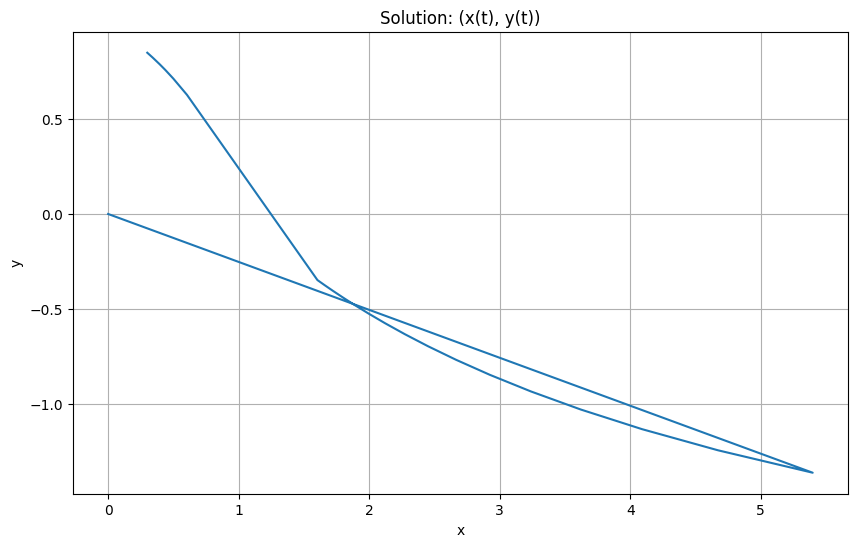

Final x: 0.0000
Final y: 0.0000


In [51]:
import numpy as np
import matplotlib.pyplot as plt

def Dmat(x, y):
    return np.array([[1/x, 1/y], [-1/(1-x), -1/(1-y)]])

def determinant(x,y):
    return np.linalg.det(Dmat(x,y))

def solve_system(x, y, n = 1):
    # Solve the linear system:
    # a/x + b/y = 1
    # a/(1-x) + b/(1-y) = 1
    A = Dmat(x,y)
    B = np.array([n,n])
    return np.linalg.solve(A, B)

def euler_method(x0, y0, t_span, num_steps):
    t = np.linspace(t_span[0], t_span[1], num_steps)
    dt = t[1] - t[0]
    
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)
    
    x[0] = x0
    y[0] = y0
    
    for i in range(1, num_steps):
        dx_dt, dy_dt = solve_system(x[i-1], y[i-1], n = i)
        x[i] = x[i-1] + dx_dt * dt
        y[i] = y[i-1] + dy_dt * dt
        if abs(determinant(x[i], y[i])) < 0.1:
            break
    
    return t, x, y

# Set initial conditions and parameters
x0, y0 = 0.3, 0.85
t_span = (0, 10)
num_steps = 1000

# Solve the system
t, x, y = euler_method(x0, y0, t_span, num_steps)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("Solution: (x(t), y(t))")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

# Print final values
print(f"Final x: {x[-1]:.4f}")
print(f"Final y: {y[-1]:.4f}")

In [3]:
# %%

from static_checks.Checker import *
from time import time

checkers = {
    "para": {"answers": {"P": 0.4, "para_P": 0.8}, "checker": ParaphraseChecker()},
    "neg": {"answers": {"P": 0.6, "not_P": 0.8}, "checker": NegChecker()},
    "cond": {
        "answers": {"P": 0.15, "Q_given_P": 0.6, "P_and_Q": 0.15},
        "checker": CondChecker(),
    },
    "andor": {
        "answers": {"P": 0.6, "Q": 0.6, "P_and_Q": 0.55, "P_or_Q": 0.6},
        "checker": AndOrChecker(),
    },
    "but": {
        "answers": {"P": 0.6, "Q_and_not_P": 0.3, "P_or_Q": 0.94},
        "checker": ButChecker(),
    },
    "condcond": {
        "answers": {
            "P": 0.5,
            "Q_given_P": 0.5,
            "R_given_P_and_Q": 0.5,
            "P_and_Q_and_R": 0.16,
        },
        "checker": CondCondChecker(),
    },
    "cons": {"answers": {"P": 0.5, "cons_P": 0.45}, "checker": ConsequenceChecker()},
    "ee": {
        "answers": {
            "P": 0.5,
            "P_given_Q": 0.25,
            "P_given_not_Q": 0.4,
            "Q": 0.15,
        },
        "checker": ExpectedEvidenceChecker(),
    },
}

for k, v in checkers.items():
    checker = v["checker"]
    if k != "ee":
        continue
    answers = v["answers"]
    print("Checker:", k)
    time0 = time()
    result_plain = checker.max_min_arbitrage(answers)
    time1 = time()
    print("No kwargs:", result_plain, "\nTime:", time1 - time0)
    print("\n\n")
    result_weighted = checker.max_min_arbitrage(answers, scoring=[0.5, 0.2])
    print("Weighted:", result_weighted, "\nTime:", time() - time1)

Checker: ee
No kwargs: ({'P': 0.4363630496557125, 'P_given_Q': 0.3009706035555113, 'P_given_not_Q': 0.4626877323758402, 'Q': 0.1449752718968944}, 0.015346055778096446) 
Time: 1.0366523265838623



Weighted: ({'P': 0.4651485812477329, 'P_given_Q': 0.32100692268953424, 'P_given_not_Q': 0.4859075019109978, 'Q': 0.14311376332541656}, 0.004398902383789746) 
Time: 1.0839760303497314


In [2]:
B, C, D = 0.31, 0.46, 0.146
A = B*D+C*(1-D)

ExpectedEvidenceChecker().min_arbitrage(
    answers={
        "P": 0.5,
        "P_given_Q": 0.25,
        "P_given_not_Q": 0.4,
        "Q": 0.15,
        },
    arbitrageur_answers={
        "P": A,
        "P_given_Q": B,
        "P_given_not_Q": C,
        "Q": D,
    },
)
# %%

0.006305518368990126

In [ ]:
# %%

from forecasters.consistent_forecaster import ConsistentForecaster
from forecasters.basic_forecaster import BasicForecaster
from common.datatypes import ForecastingQuestion
from static_checks.Checker import *
from time import time

cf = ConsistentForecaster(
    BasicForecaster(),
    checks=[
        NegChecker(),
        AndOrChecker(),
        CondChecker(),
        ParaphraseChecker(),
    ],
)
fq = ForecastingQuestion(
    title="Will Manhattan have a skyscraper a mile tall by 2030?",
    body=(
        "Resolves YES if at any point before 2030, there is at least "
        "one building in the NYC Borough of Manhattan (based on current "
        "geographic boundaries) that is at least a mile tall."
    ),
    resolution_date="2030-01-01T00:00:00",
    question_type="binary",
    data_source="manifold",
    url="https://www.metaculus.com/questions/12345/",
    metadata={"foo": "bar"},
    resolution=None,
)

import asyncio

# x = cf.call(fq)
x = asyncio.run(cf.call_async(
    fq,
    bq_func_kwargs={"model": "gpt-4o-mini"},
    instantiation_kwargs={"model": "gpt-4o-mini"},
    model="gpt-4o-mini",
))
# x = asyncio.run(cf.call_async(fq))

In [ ]:
# %%

print(f"{x=}")

raise

In [ ]:
# %%

from static_checks.Checker import *
from time import time

checkers = {
    "para": {"answers": {"P": 0.4, "para_P": 0.43}, "checker": ParaphraseChecker()},
    "neg": {"answers": {"P": 0.6, "not_P": 0.57}, "checker": NegChecker()},
    "cond": {
        "answers": {"P": 0.15, "Q_given_P": 0.6, "P_and_Q": 0.15},
        "checker": CondChecker(),
    },
    "andor": {
        "answers": {"P": 0.6, "Q": 0.6, "P_and_Q": 0.55, "P_or_Q": 0.6},
        "checker": AndOrChecker(),
    },
    "but": {
        "answers": {"P": 0.6, "Q_and_not_P": 0.3, "P_or_Q": 0.94},
        "checker": ButChecker(),
    },
    "condcond": {
        "answers": {
            "P": 0.5,
            "Q_given_P": 0.5,
            "R_given_P_and_Q": 0.5,
            "P_and_Q_and_R": 0.16,
        },
        "checker": CondCondChecker(),
    },
    "cons": {"answers": {"P": 0.5, "cons_P": 0.45}, "checker": ConsequenceChecker()},
}

for k, v in checkers.items():
    checker = v["checker"]
    answers = v["answers"]
    if k != "cons":
        continue
    print("Checker:", k)
    time0 = time()
    result_shgo = checker.max_min_arbitrage(answers, methods=("shgo",))
    time1 = time()
    print("SHGO:", result_shgo, "\nTime:", time1 - time0)
    result_diff_evol = checker.max_min_arbitrage(
        answers, methods=("differential_evolution",)
    )
    time2 = time()
    print("Diff Evolution:", result_diff_evol, "\nTime:", time2 - time1)
    result_dual_annealing = checker.max_min_arbitrage(
        answers, methods=("dual_annealing",)
    )
    time3 = time()
    print("Dual Annealing:", result_dual_annealing, "\nTime:", time3 - time2)
    result_basinhopping = checker.max_min_arbitrage(answers, methods=("basinhopping",))
    time4 = time()
    print("Basinhopping:", result_basinhopping, "\nTime:", time4 - time3)
    result_plain = checker.max_min_arbitrage(answers)
    time5 = time()
    print("No kwargs:", result_plain, "\nTime:", time5 - time4)
    print("\n\n")


# print('----------------')
# print(CondChecker().min_arbitrage(ex, exa))
# print('----------------')
# print(CondChecker().arbitrage(outcome1, ex, exa))
# print(CondChecker().arbitrage(outcome2, ex, exa))
# print(CondChecker().arbitrage(outcome3, ex, exa))
# print('----------------')

In [ ]:
# %%

import json
from common.datatypes import (
    ForecastingQuestion_stripped,
    ForecastingQuestion,
    Prob_cot,
    Prob,
    PlainText,
)
from common.llm_utils import query_api_chat_sync, query_api_chat_sync_native
import os

fq = ForecastingQuestion(
    title="Will Manhattan have a skyscraper a mile tall by 2030?",
    body=(
        "Resolves YES if at any point before 2030, there is at least "
        "one building in the NYC Borough of Manhattan (based on current "
        "geographic boundaries) that is at least a mile tall."
    ),
    resolution_date="2030-01-01T00:00:00",
    question_type="binary",
    data_source="manifold",
    url="https://www.metaculus.com/questions/12345/",
    metadata={"foo": "bar"},
    resolution=None,
)

fqs = ForecastingQuestion_stripped(
    title="Will Manhattan have a skyscraper a mile tall by 2030?",
    body=(
        "Resolves YES if at any point before 2030, there is at least "
        "one building in the NYC Borough of Manhattan (based on current "
        "geographic boundaries) that is at least a mile tall."
    ),
)

print(fqs.__str__())

In [ ]:
# %%

# os.environ["USE_OPENROUTER"] = "True"
messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant. Summarize the question for the user.",
    },
    {"role": "user", "content": fq.__str__()},
]
# response = query_api_chat_sync(messages=messages, verbose=True, model="mistralai/mistral-large")